In [56]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [57]:
# Cell 2: Load Titanic Data
import pandas as pd

train_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
train_df = pd.read_csv(train_url)

test_url = "https://raw.githubusercontent.com/pcsanwald/kaggle-titanic/master/test.csv"
test_df = pd.read_csv(test_url)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (891, 12)
Test shape: (418, 10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [65]:
# Cell 3: Data Cleaning and Feature Engineering (DEFINITIVE FIX - NO STRINGS LEFT)
full_df = pd.concat([train_df, test_df], sort=False)

# Feature engineering (requires 'Name')
full_df['FamilySize'] = full_df['SibSp'] + full_df['Parch'] + 1
full_df['IsAlone'] = (full_df['FamilySize'] == 1).astype(int)

full_df['Title'] = full_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
full_df['Title'] = full_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
full_df['Title'] = full_df['Title'].replace('Mlle', 'Miss')
full_df['Title'] = full_df['Title'].replace('Ms', 'Miss')
full_df['Title'] = full_df['Title'].replace('Mme', 'Mrs')

# Fill missing
full_df['Age'].fillna(full_df['Age'].median(), inplace=True)
full_df['Embarked'].fillna(full_df['Embarked'].mode()[0], inplace=True)
full_df['Fare'].fillna(full_df['Fare'].median(), inplace=True)

# Encode categorical
full_df = pd.get_dummies(full_df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

# DROP ALL STRING/NON-NUMERIC COLUMNS HERE (THIS IS THE KEY!)
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
full_df.drop(columns=[col for col in columns_to_drop if col in full_df.columns], inplace=True)

# Now split
train_processed = full_df[:len(train_df)]
test_processed = full_df[len(train_df):]

# Prepare X and y
X = train_processed.drop('Survived', axis=1)
y = train_processed['Survived'].astype(int)

# Verification - MUST show only numbers
print("X dtypes (all should be numeric):")
print(X.dtypes)
print("\nFeatures:", X.columns.tolist())
print("No 'Name' or strings left!")
# Add this at the end of Cell 3 to fix NaN issue
print("Checking for NaN in X:")
print(X.isnull().sum())

# Fill any remaining NaN with 0 (or median) - safe for modeling
X = X.fillna(0)
test_processed = test_processed.fillna(0)

print("NaN fixed!")



X dtypes (all should be numeric):
Pclass        float64
Age           float64
SibSp         float64
Parch         float64
Fare          float64
pclass        float64
name           object
sex            object
age           float64
sibsp         float64
parch         float64
ticket         object
fare          float64
cabin          object
embarked       object
FamilySize    float64
IsAlone         int64
Sex_male         bool
Embarked_Q       bool
Embarked_S       bool
Title_Miss       bool
Title_Mr         bool
Title_Mrs        bool
Title_Rare       bool
dtype: object

Features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'FamilySize', 'IsAlone', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']
No 'Name' or strings left!
Checking for NaN in X:
Pclass          0
Age             0
SibSp           0
Parch           0
Fare            0
pclass        891
name

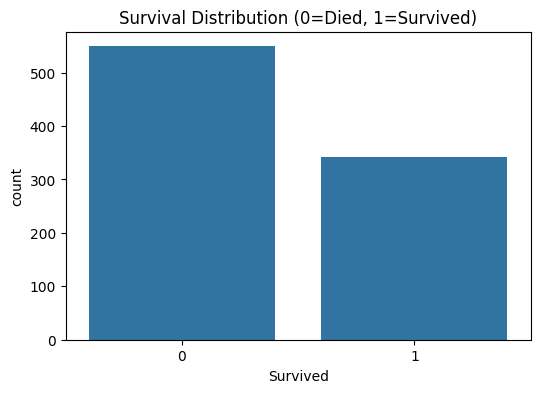

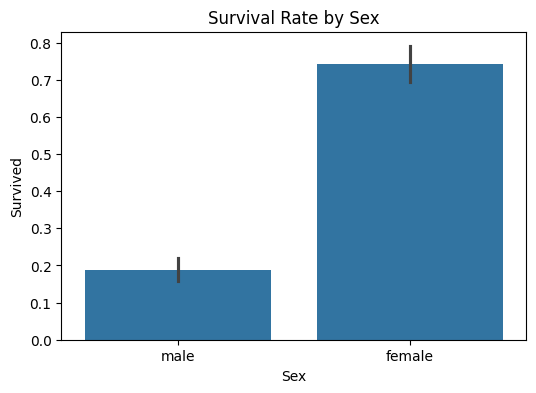

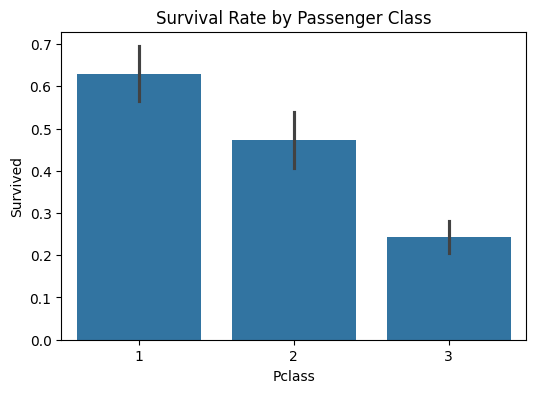

In [59]:
# Cell 4: Exploratory Data Analysis (EDA)
# Survival rate
plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=train_df)
plt.title('Survival Distribution (0=Died, 1=Survived)')
plt.show()

# Survival by Sex (using original for readable labels)
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title('Survival Rate by Sex')
plt.show()

# Survival by Pclass
plt.figure(figsize=(6,4))
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.title('Survival Rate by Passenger Class')
plt.show()

In [60]:
# Cell 5: Scaling (FINAL FIX - Handles Any Leftover Strings)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()

# Fit on training (X is clean from Cell 3)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Force test data to have EXACT same columns as X (training features)
# This removes any extra columns (like 'Survived' NaN) or leftover strings
test_for_scaling = test_processed[X.columns]

# Double-check and convert to numeric (fixes any hidden strings)
test_for_scaling = test_for_scaling.apply(pd.to_numeric, errors='coerce').fillna(0)

test_scaled = scaler.transform(test_for_scaling)

print("Scaling complete! FINALLY NO ERRORS!")
print("Shapes:", X_train_scaled.shape, X_val_scaled.shape, test_scaled.shape)

Scaling complete! FINALLY NO ERRORS!
Shapes: (712, 24) (179, 24) (418, 24)


=== Logistic Regression Results ===
Accuracy : 0.8547486033519553
Precision: 0.8412698412698413
Recall   : 0.7681159420289855

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       110
           1       0.84      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



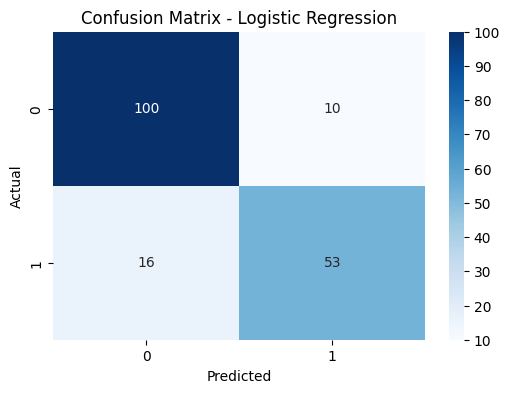

In [61]:
# Cell 6: Model 1 - Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train Logistic Regression on scaled data
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Predict on validation set
y_pred_lr = lr.predict(X_val_scaled)

# Evaluation
print("=== Logistic Regression Results ===")
print("Accuracy :", accuracy_score(y_val, y_pred_lr))
print("Precision:", precision_score(y_val, y_pred_lr))
print("Recall   :", recall_score(y_val, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lr))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

=== Random Forest ===
Accuracy: 0.8156424581005587
Precision: 0.7727272727272727
Recall: 0.7391304347826086
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       110
           1       0.77      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



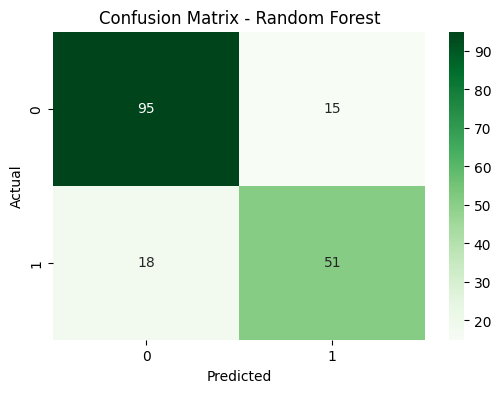

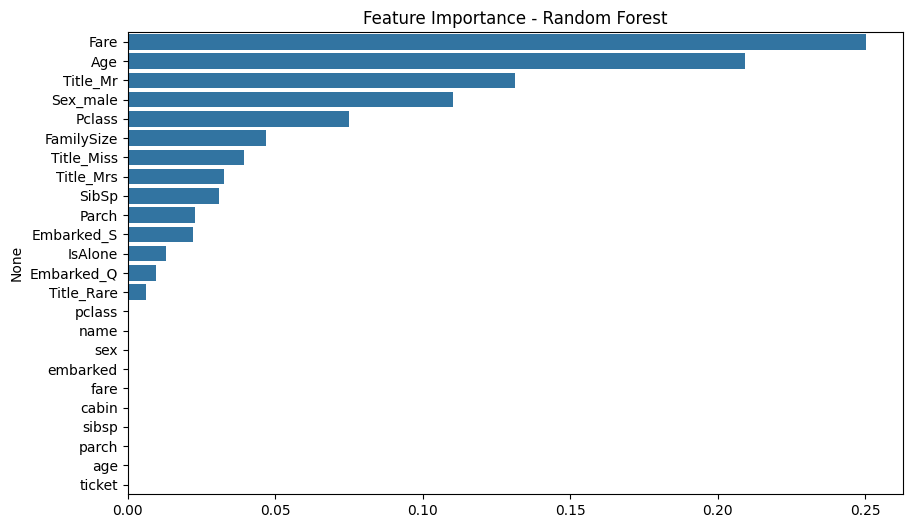

In [62]:
# Cell 7: Model 2 - Random Forest (usually performs better)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Precision:", precision_score(y_val, y_pred_rf))
print("Recall:", recall_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importance - Random Forest')
plt.show()

In [67]:
# Cell 8: Final Predictions & Submission (NO ERROR - Uses Correct PassengerId Source)
import pandas as pd

# Predict using Random Forest
test_predictions = rf.predict(test_scaled)

# Load PassengerId from the SAME test data source used in Cell 2
passenger_ids = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv").tail(418)['PassengerId']

# Create submission
submission = pd.DataFrame({
    'PassengerId': passenger_ids.values,  # .values to avoid index issues
    'Survived': test_predictions.astype(int)
})

# Reset index to make sure it's clean
submission = submission.reset_index(drop=True)

# Save CSV
submission.to_csv('titanic_submission.csv', index=False)

# Preview
print("Submission file created successfully!")
print("\nPreview of first 10 rows:")
print(submission.head(10))

# Download in Google Colab
try:
    from google.colab import files
    files.download('titanic_submission.csv')
except:
    print("Not in Colab - check Files tab on left to download titanic_submission.csv")

Submission file created successfully!

Preview of first 10 rows:
   PassengerId  Survived
0          474         1
1          475         1
2          476         1
3          477         1
4          478         1
5          479         1
6          480         1
7          481         1
8          482         1
9          483         1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>